<a href="https://colab.research.google.com/github/geraldlab/nlp_machine_learning/blob/main/Text_summarizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Using Machine Learning for Automatic Text summarization**

**1. Introduction**

Nowadays, a lot of text documents are produced in various areas. Due to the limited amount of time, most readers prefer to get the gist of the documents before investing their time reading the entire document. Unfortunately, most document on the web do not have summaries and having an automated routine that can provide the gist could provide huge resource saving for the readers. Summaries can be categorised as either extractive or abstractive:

1. **Abstractive Summary**: The network creates new sentences to encapsulate maximum gist of the article and generates that as output. The sentences in the summary may or may not be contained in the article.

2. **Extractive Summary**: the network calculates the most important sentences from the article and gets them together to provide the most meaningful information from the article.




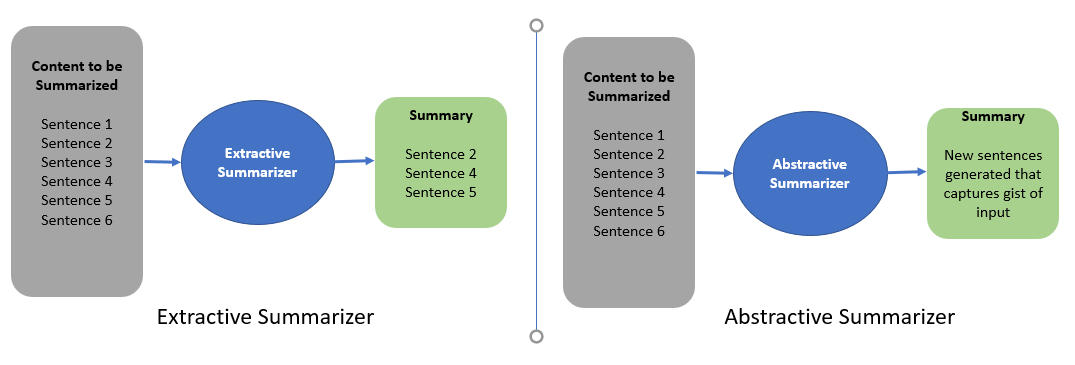

Nowadays there are various machine learning model for text summarisation. This noteboook demostrates three recent models for summarization:
1. **Gensim summariser** uses the gensim library that is based on a TextRanking algorithm to perform **extractive summarisation**. The summariser first pre-process the given text (*stop words removal, punctuation removal and stemming*) then makes a graph with sentences as the vertices.The edges of the graph denotes similarity between the two sentences at the vertices. A PageRank algorithm is run on the weighted graph and highest scoring vertices are appended to the summary. The ratio or the word count is used to determine the the number of vertices to be appended to the summary.

2. **BERT Summariser** is built using the transformers library to generate **extractive summarizations**. The summariser first embeds the sentences, then runs a clustering algorithm to find sentences that are closest to the cluster's centroids. In addition, it uses coreference techniques to resolve words in summaries that need more context.

3. **T5 (Text-to-Text Transfer Transformer)** generates **abstractive summaries** and uses an encoder-decoder model pre-trained on a multi-task mixture of unsupervised and supervised tasks and for which each task is converted into a text-to-text format. The input text is tokenized and mapped to sequence of embeddings that are passed into an encoder. The output from the encoder is then feed to a decoder. The encoder and decoder uses self-attention. Furthermore, the decoder also uses a form of autoregressive or causal selfattention that allows the model to attend to past outputs. The output of the final decoder block is fed into a dense layer with a softmax output.

*Note: Transformer is one of the most versatile deep learning models.*

**2. Preparing Environment and Installing Libraries**

Below code install the necessary libraries

In [1]:
%%capture cell_output

#install transformer
!pip install install transformers torch

#modules for BERT summariser
! pip install bert-extractive-summarizer
! pip install spacy==2.1.3
! pip install neuralcoref

! python -m spacy download en_core_web_md

#module used in T5
!pip install sentencepiece

In [2]:
import os, sys
import re

from termcolor import colored #library for printing colored text
import textwrap

**3. Prepare Content to Summarise**

To demostrate these automatic text summarization techniques, content was scrapped from the web using Beautiful Soup python library.

Below cell contains code for scrapping web page.

In [3]:
#helper function to scrap web page content
from bs4 import BeautifulSoup
from bs4.element import Comment

import urllib.request
import urllib.error
import ssl

def get_text_from_html(url):
    try:
       with urllib.request.urlopen(url) as url:
            raw_html = url.read()
   
            ## creating a BeautifulSoup object
            soup = BeautifulSoup(raw_html,"lxml")
            
            pg_title = soup.find('title')
            
            title = ""
            if pg_title:
                title = pg_title.text
                
            content = "".join([p.text for p in soup.find_all("p")])
                      
            return title.replace('\n', '').replace('\r', ''), content.replace('\n', ' ').replace('\r', '')

    except urllib.error.URLError as e:
       return e.reason, e.reason

Get content to summmarise and preview it.

In [4]:
url = "https://www.un.org/sg/en/content/sg/statement/2021-01-10/secretary-generals-remarks-the-commemoration-of-the-75th-anniversary-of-the-first-meeting-of-the-united-nations-general-assembly-delivered"

page_title, page_content = get_text_from_html(url)

#Preview the content of the web page
print(colored('Title : ' + page_title[:100] + ' ....', 'red'))
print(colored(textwrap.fill(page_content[:1000], 100) + ' .....', 'blue'))
print(colored('Number of words : ' , 'red'), len(page_content.split()))


Title : Secretary-General's Remarks at the Commemoration of the 75th Anniversary of the First Meeting of the ....
Lord Ahmad, Distinguished guests, Ladies and gentlemen, Dear young people,It is a special privilege
to address you today, on the 75th anniversary of the first meeting of the General Assembly of the
United Nations, which took place in London.   First of all, let me say how deeply I regret not to be
physically present with you to commemorate this historic event.I want to express my total solidarity
with the British people in these challenging times of the pandemic. My sincere condolences to the
families of those who have perished and my admiration for the courage and sacrifice of the health
workers and others on the frontlines, rescuing people at the risk of their own lives.  I want to pay
tribute to one of the organizers of the first meeting of the General Assembly, the legendary Sir
Brian Urquhart, who passed away last week. Sir Brian’s combination of dedication, integrity 

**3. Implementing the summarisers**

**3.a. Gensim summariser**

Below code implements the Gensim summariser to summarise the given text to 200 words.

In [5]:
from gensim.summarization.summarizer import summarize 
from gensim.summarization import keywords 

# Summary (100 words) 
gen_summ_words = summarize(page_content, word_count = 130) 

**3.b. BERT extractive summariser**

Below code implements the BERT summariser.

In [6]:
from transformers import *
from summarizer import Summarizer

model = Summarizer()

result = model(page_content, num_sentences=10)
bert_summary = ''.join(result)

**3.c T5 summariser - abstractive summariser**

Below code implements the T5 summariser

In [7]:
# initialize the T5 model architecture and weights
model = T5ForConditionalGeneration.from_pretrained("t5-small")

# initialize the model tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")

In [8]:
# encode the input into tensor of integers using tokenizer, 
inputs = tokenizer.encode("summarize: " + page_content, return_tensors="pt", max_length=10240, truncation=True)

# run T5 model to generate the summarization output
outputs = model.generate( inputs, 
                         min_length=110, max_length=200,
                         length_penalty=2.0, 
                         num_beams=4, 
                         early_stopping=True)

#detokenize the summary
t5_summary = tokenizer.decode(outputs[0][1:-1])

**4. Results**

The results of the summarisers are displayed below.

In [9]:
print("Summarised Content") 
print('==================')
print('1. Gensim with pageRank') 
print('=======================')
print(textwrap.fill(gen_summ_words, 100))
print("")
print(colored('Number of words :' , 'red'), len(gen_summ_words.split()))
print('=======================')
print('2. BERT summariser') 
print('=======================')
print(textwrap.fill(bert_summary, 100))
print("")
print(colored('Number of words :' , 'red'), len(bert_summary.split()))
print('=======================')
print('3. T5 summariser') 
print('=======================')
print(textwrap.fill(t5_summary, 100))
print("")
print(colored('Number of words : ', 'red'), len(t5_summary.split()))

Summarised Content
1. Gensim with pageRank
At the national level, I have called for a new social contract between people, governments, the
private sector, civil society and more, to tackle the roots of inequality with fair taxation on
income and wealth, universal benefits, and opportunities for all.We need a strong emphasis on
quality education for all, not forgetting girls, and on access to digital technology, as powerful
equalizers and enablers.Investment in the recovery must put economies and societies on stronger
foundations: human rights and dignity; peaceful cooperation; respect for other species, for our
planet and its boundaries.The pandemic is a human tragedy – but it can also be an opportunity.The
past months have shown the huge transformations that are possible, when there is political will and
consensus on the way forward.Our blueprint already exists.

Number of words : 128
2. BERT summariser
Lord Ahmad, Distinguished guests, Ladies and gentlemen, Dear young people,It is a 

**5. Conclusion**

Three approaches for automatic text summarisation have been demonstrated. Gensim summariser is one of the oldest summarisers while T5 and BERT summariser are the most recent summarisers. T5 was released in 2020 while BERT in 2019.

The T5 model produced a brief legible abstractive summary with 75 words that captured the gist of the source document which had 1,756 words. Some of the sentence in the T5 summary were not in the source document. It is worth noting that T5 uses transfer learning, where a model is first pre-trained on a data-rich task before being fine-tuned on a downstream task for the target domain. Hence, the summary produced by T5 can be improved by fine-tuning the model with target domain inputs. 


**Reference**

Miller, D. 2020 *Bert Extractive Summarizer*, url: https://pypi.org/project/bert-extractive-summarizer/

Plates, P.V 2020 *How to generate text: using different decoding methods for language generation with Transformer*, url: https://huggingface.co/blog/how-to-generate 

Raffel, Colin et al. (2020) Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer, *Journal of Machine Learning Research*, 21, pp. 1-67, url: https://arxiv.org/abs/1910.10683

The Hugging Face Team 2020 *T5*, url: https://huggingface.co/transformers/model_doc/t5.html

Uberoi, A. 2020 *Python | Extractive Text Summarization using Gensim*, url: https://www.geeksforgeeks.org/python-extractive-text-summarization-using-gensim/